## Importing Libraries

In [1]:
import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import demoji

In [2]:
# Read both the files into pandas dataframe
df=pd.read_excel('Comments - FilterCopy Videos.xlsx','Every Exam Preparation Ever')
df2=pd.read_excel('Comments - FilterCopy Videos.xlsx','If Salary Were A Person')

### Raw Analysis of Files

In [3]:
df.head()

,Name,Comment,Time,Likes,Reply Count
0,M Square,What a starting🤣🤣🤣,2021-09-16T11:19:50Z,0,0
1,Kushi Jakhotia,All the best for your exam aachese padhna exam...,2021-09-16T11:19:11Z,0,0
2,p i n k p e a c e e,Idk why exam ki prep mein bhi alag h feel aati...,2021-09-16T10:13:06Z,0,0
3,Anurag Bhattarai,I am watching this just hours before my exam,2021-09-16T08:34:14Z,0,0
4,Keya Das,"Everybody... 😂 holi pe nasha karke, rabbi ne c...",2021-09-16T08:13:41Z,0,0


In [4]:
df2.head()

,Name,Comment,Time,Likes,Reply Count
0,FilterCopy,What do you spend your salary on? Comment belo...,2018-07-06T06:23:53Z,2951,192
1,AAYAN KUMAR,i was looking at veer at the beer cafe and he ...,2021-09-16T07:29:31Z,0,0
2,Abhi Borthakur,"And here people like us, whose salary come wit...",2021-09-16T02:57:02Z,0,0
3,Soham Waikar,The husband is nothing but salary in men,2021-09-15T08:18:18Z,0,0
4,Yuvraj Barve,this was the first video of Filtercopy i had s...,2021-09-15T06:57:05Z,0,0


In [5]:
print("No. of Comments in Every Exam Preparation Ever Video:",df.shape[0])

No. of Comments in Every Exam Preparation Ever Video: 5994


In [6]:
print("No. of Comments in If Salary Were A person Video: ",df2.shape[0])

No. of Comments in If Salary Were A person Video:  11019


### NULL Check And Empty Comments

In [7]:
print("Number of Null Comments in first DataFrame: ", df['Comment'].isnull().sum(),'\n'
"Number of Null Comments in second DataFrame: ",df2['Comment'].isnull().sum())

Number of Null Comments in first DataFrame:  0 
Number of Null Comments in second DataFrame:  0


Alternatly you can get the Non-Null count and dtype of both the dataframes via info() method of pandas

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         5993 non-null   object
 1   Comment      5994 non-null   object
 2   Time         5994 non-null   object
 3   Likes        5994 non-null   int64 
 4   Reply Count  5994 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 234.3+ KB


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11019 entries, 0 to 11018
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         11018 non-null  object
 1   Comment      11019 non-null  object
 2   Time         11019 non-null  object
 3   Likes        11019 non-null  int64 
 4   Reply Count  11019 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 430.6+ KB


### Descriptive Statistics of Data

In [10]:
df.describe()

,Likes,Reply Count
count,5994.000000,5994.000000
mean,14.607441,0.224558
std,233.310395,2.342013
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,13225.000000,79.000000


In [11]:
df2.describe()

,Likes,Reply Count
count,11019.000000,11019.000000
mean,7.181595,0.164897
std,131.595687,2.650231
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,6644.000000,192.000000


### Persons With More Than One Comment 

In [12]:
# A function that returns shape od dataframe for people with more than one comment.
def grouped_calculation(df):    
    grouped_name_comments=df.groupby('Name')['Comment'].agg(list).reset_index()
    grouped_name_comments['comment_count']=grouped_name_comments['Comment'].apply(lambda x:len(x))
    return grouped_name_comments[grouped_name_comments['comment_count']>1].shape[0]

In [13]:
print("People with More Than one comment in Exam Preparation Ever Video: ",grouped_calculation(df.copy()))
print("People with More Than one comment in If Salary Were A person Video: ",grouped_calculation(df2.copy()))

People with More Than one comment in Exam Preparation Ever Video:  270
People with More Than one comment in If Salary Were A person Video:  446


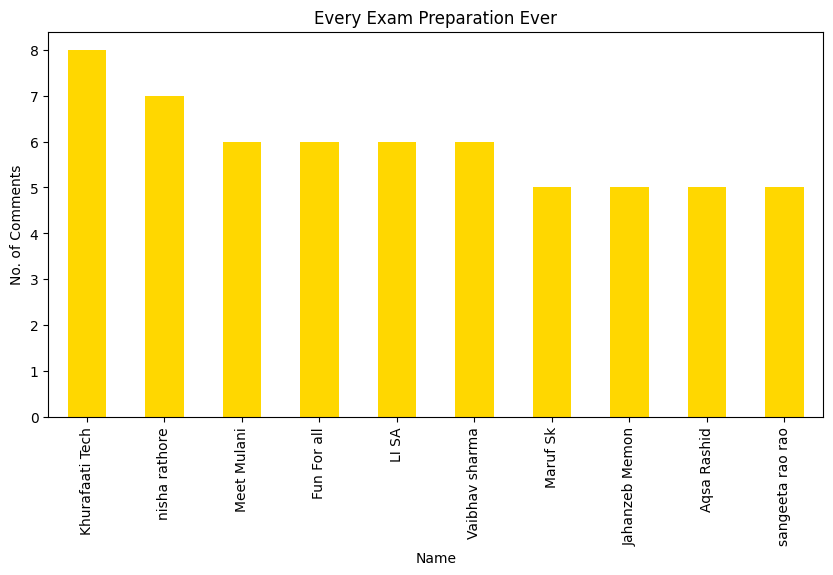

In [14]:
# A bar graph of top 10 persons with most number of comments
df['Name'].value_counts()[:10].plot(kind='bar',color=['gold'],figsize=(10,5))
plt.title('Every Exam Preparation Ever')
plt.xlabel('Name',fontsize=10)
plt.ylabel('No. of Comments',fontsize=10)
plt.show()

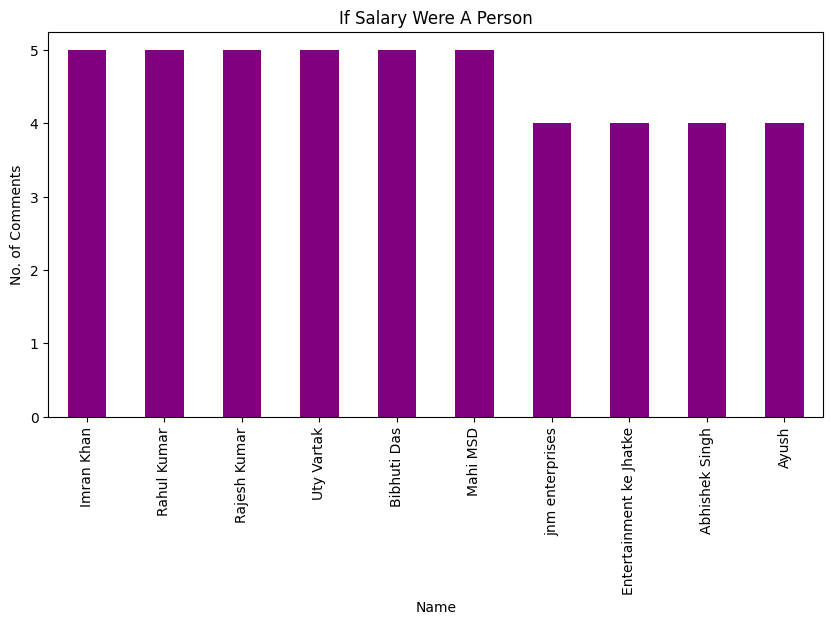

In [15]:
# A bar graph of top 10 persons with most number of comments
df2['Name'].value_counts()[:10].plot(kind='bar',color=['purple'],figsize=(10,5))
plt.title('If Salary Were A Person')
plt.xlabel('Name',fontsize=10)
plt.ylabel('No. of Comments',fontsize=10)
plt.show()

### Sentiment Analysis of Comments

For the purpose of Sentiment Analysis we are going to use a transformer based model from hugging face API that can extract out the sentiment from the text. 

Transformers are something that uses Multi head Attention system with positional embeddings to represent words and texts in form of vector.

Since the comments are in Hinglish(Hindi+English) we can not use a our traditional models that are trained in English Languages therefore we are going to use a model that is trained in Hinglish Language. This Model is a fine-tuned model of bert-base-multilingual-codemixed-cased-sentiment.

In [16]:
tokenizer = AutoTokenizer.from_pretrained("ganeshkharad/gk-hinglish-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("ganeshkharad/gk-hinglish-sentiment")
classifier=pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)

In the model card the imported model output mapping contains 3 lables 
- LABEL_0 = Negative
- LABEL_1 = Nuetral
- LABEL_2 = Positive

In [17]:
# Change texts to vector and feed it to classifier to assign it to three corrosponding labels
df['Sentiment']=df['Comment'].apply(lambda x:classifier(str(x))[0]['label'] if(len(str(x))<1000) else None)

In [18]:
mapper={'LABEL_2':'Posative','LABEL_1':'Neutral','LABEL_0':'Negative'}

In [19]:
## Map these model labels to your general language sentiments
df['Sentiment']=df['Sentiment'].apply(lambda x:mapper[x] if(x!=None) else None)

### Analysing the Sentiments

In [20]:
#posative
df[df['Sentiment']=='Posative'][:10]['Comment'].values

array(['What a starting🤣🤣🤣',
       'All the best for your exam aachese padhna exam ke liye',
       'Bhai HC Verma sir jinda hai', 'Holi ka mast scene',
       'Truely for my chemistry exam I remembered the same song 🤣🤣',
       'my kindergarden teachers name was Gauri',
       'papa and mummy vala scene funniest tha',
       'Don&#39;t watch this video during your studies or you will 😂😂',
       'Periodic table wali trick mne apply kr li<br>Thanks for this🤣',
       'Cerseii 😂😂<br>Game of thrones'], dtype=object)

In [21]:
# Negative 
df[df['Sentiment']=='Negative'][40:50]['Comment'].values

array(['Exam Dene ja raha hun, Mahishmati ki Jang ladne nahi ja raha hun',
       'Kyu ki youtube mat chodn', 'Pass mat hona',
       '<a href="https://www.youtube.com/watch?v=Xd5yIXCHeEo&amp;t=4m14s">4:14</a> you should not disrespect HC verma sir',
       'EXAM CANCEL', 'did he abuse H C verma?',
       'Hc verma part was sooo gooood!!😅😂😂😂',
       '<b>jo 5th chapter me 3rd law of motion hai,wo konsa jungli mal fukar likha hai</b> 🤣🤣',
       'Agar HC Verma sir Unacademy par parha rahe hotey, toh himmat nahi hoti inki unpar mazaak banaane ki.. Unacademy ke chamchon.👎👎👎👎👎👎',
       'Shameful video HC Verma sir ko aise nhi bolna chahiye tha worst video I have ever seen👎👎👎👎👎'],
      dtype=object)

In [22]:
#Neutral
df[df['Sentiment']=='Neutral'][20:30]['Comment'].values

array(['Filter copy pe Ashish ??', 'Ashish Op', '😂😂',
       'Charas ganja mereko pyara🍺',
       'After 3 years YouTube recommend me this 😔😔😒',
       'Periodic table scene was lit😂😂🤘',
       'Holi pe nasha karke rabbi ne charas fooka it really helps me in my chemistry exam',
       'My exam is in 1 hrs...Mangalsutra padh leta hu....Raksha karega',
       '3rd law of motion 🤣🤣🤣🤣🤣 same I am studying as a student inertia',
       'Who just came here for Ashu'], dtype=object)

Our **Predictions** of Sentiment looks to be pretty accurate. Though Some of them are questionable, its mostly right.

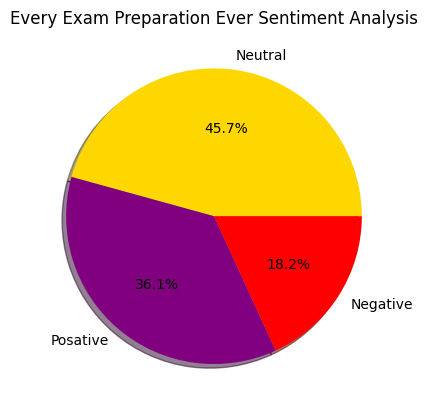

In [23]:
plt.pie(df['Sentiment'].value_counts().values,labels=['Neutral','Posative','Negative'],colors=['gold','purple','red'],normalize=True, textprops = dict(color ="black"),shadow=True,autopct='%1.1f%%')
plt.title('Every Exam Preparation Ever Sentiment Analysis')
plt.show()

Posative Comments Includes 
- Appreciation for the Peroidic Table Learning Trick and most of them found the interaction of Ashish with parents hilarious.

Negative Comments mostly include name calling of HC Verma 

In [24]:
df2['Sentiment']=df2['Comment'].apply(lambda x:classifier(str(x))[0]['label'] if(len(str(x))<1000) else None)
df2['Sentiment']=df2['Sentiment'].apply(lambda x:mapper[x] if(x!=None) else None)

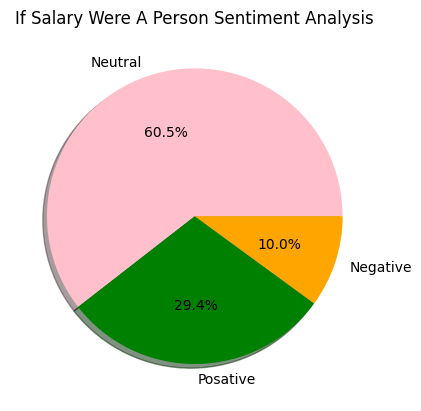

In [25]:
plt.pie(df2['Sentiment'].value_counts().values,labels=['Neutral','Posative','Negative'],colors=['pink','green','orange'],normalize=True, textprops = dict(color ="black"),shadow=True,autopct='%1.1f%%')
plt.title('If Salary Were A Person Sentiment Analysis')
plt.show()

Negative Reviews for if Salary Were a Person Include Comments Such as: 
- Source of Income of Girl and concerns over her job as she is seen free during daytime. 
- Question over why a boy is being portrayed as Salary.Some took it in a sense it is stereotypical to show the girl trying to spend the money and the boy(portrayed as Salary) is concerned over this.

Posative Reviews applauds the **Creativity of video** and the **performace of the Cast**.

### Comment Tone Comparision of Two Videos

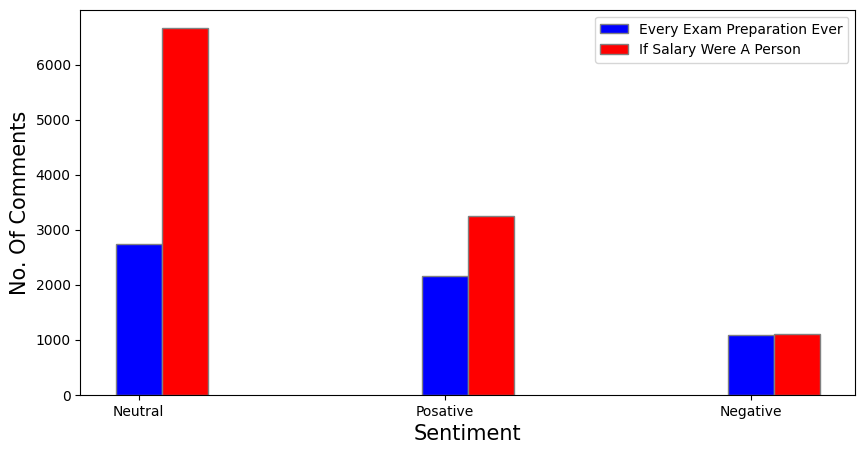

In [28]:
barWidth = 0.15
fig=plt.subplots(figsize=(10,5))
br1 = np.arange(len(df['Sentiment'].value_counts()))
br2 = [x + barWidth for x in br1]
plt.bar(br1,df['Sentiment'].value_counts(),color='blue',label='Every Exam Preparation Ever',width=barWidth,edgecolor='grey')
plt.bar(br2,df2['Sentiment'].value_counts(),color='red',label='If Salary Were A Person',width=barWidth,edgecolor='grey')
plt.xlabel('Sentiment', fontsize = 15)
plt.ylabel('No. Of Comments', fontsize = 15)
plt.xticks([0,1,2],['Neutral','Posative','Negative'])
plt.legend()
plt.show()

In [29]:
def generate_wordcloud(text,title):
    wordcloud = WordCloud(background_color = "black",width=3000,height = 1500).generate(text)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [30]:
stopwords= ['href=','xd5yixcheeo','href','https','br','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 
 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
  'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', 
  "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
def return_r_wc(x):
    comment_string=''
    for comment in x['Comment']:
        try:
            comment_string+=comment
        except:
            pass
    querywords = word_tokenize(comment_string)
    resultwords  = [word for word in querywords if not word.lower() in stopwords]
    result = ' '.join(resultwords)
    return result

### WordCloud For Every Exam Preparation

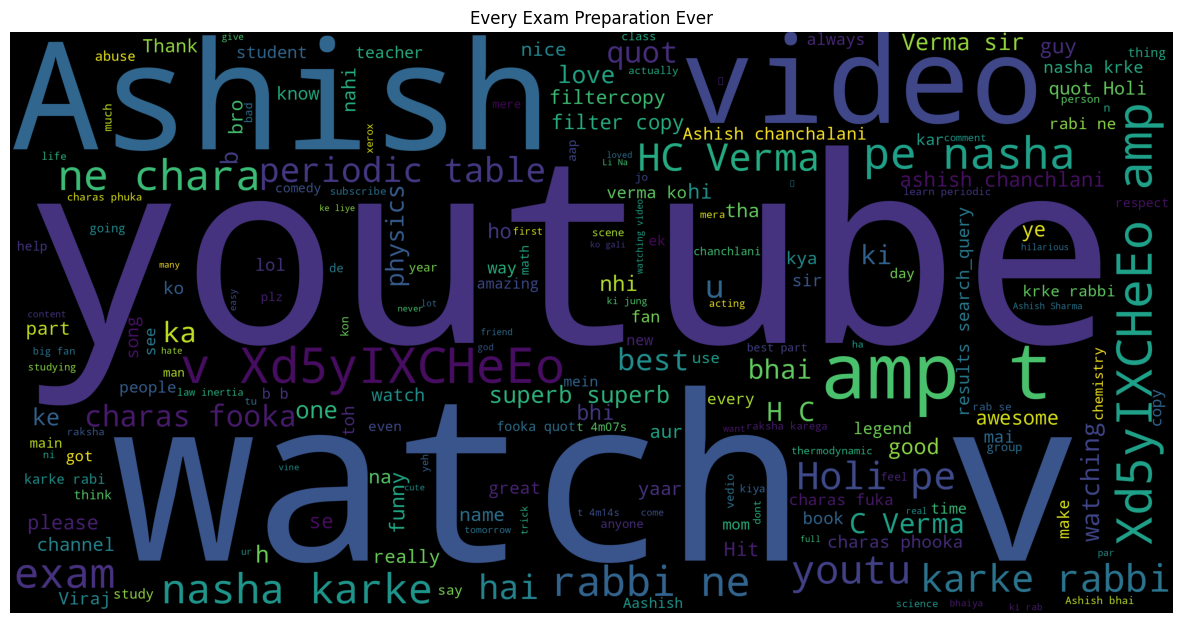

In [34]:
generate_wordcloud(return_r_wc(df.copy()),"Every Exam Preparation Ever")

### WordCloud For If Salary Were A Person

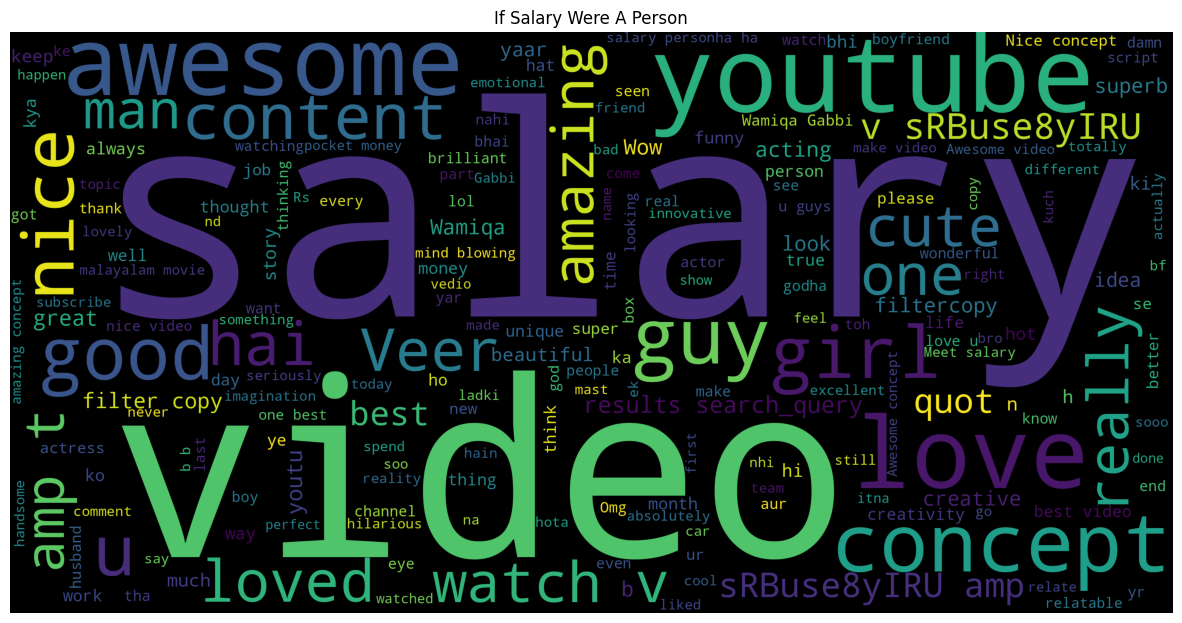

In [35]:
generate_wordcloud(return_r_wc(df2.copy()),"If Salary Were A Person")

## Emojis Breakdown

### Every Exam Preparation

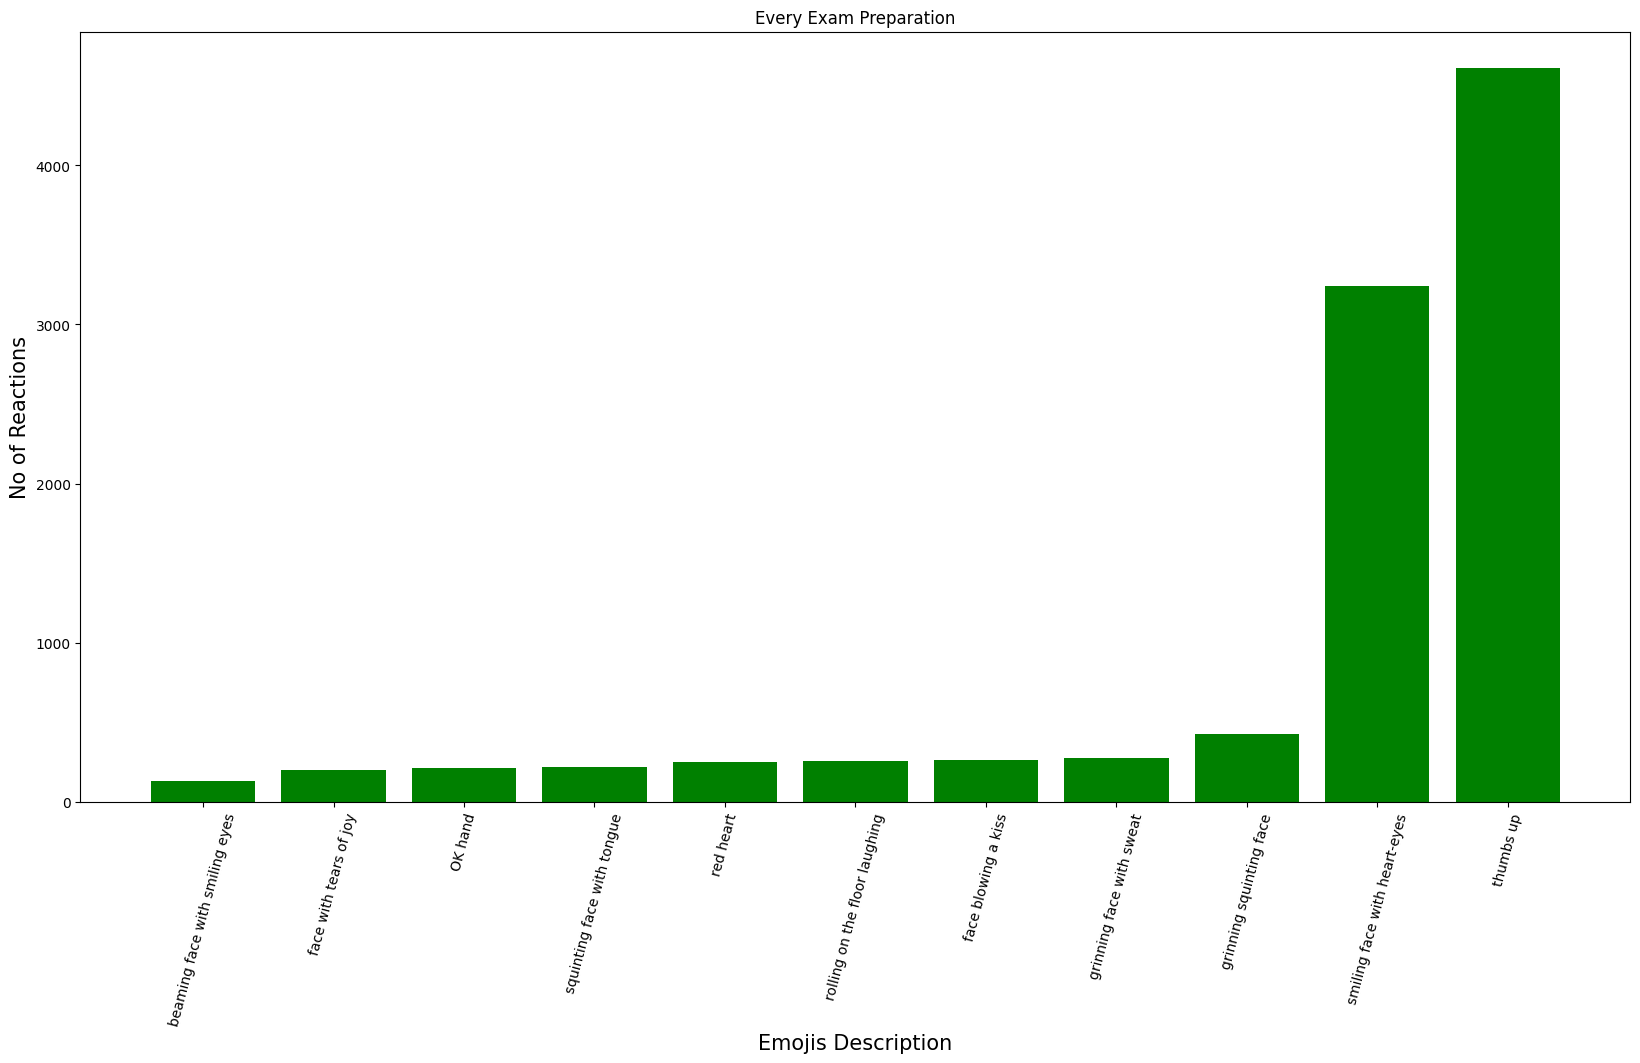

In [37]:
from collections import Counter
comment_string=''
for comment in df['Comment']:
    try:
        comment_string+=comment
    except:
        pass
emos=demoji.findall(comment_string)
count_all=Counter(comment_string)
count_emos={}
for i in emos:
    if(count_all.get(i)!=None):
        count_emos[i]=count_all.get(i)
    else:
        pass
count_emos={k: v for k, v in sorted(count_emos.items(), key=lambda item: item[1])}
label=" ".join(list(count_emos.keys())[-11:])
label=list(demoji.findall(label).values())
y=list(count_emos.values())[-11:]
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(label,y,color='green')
plt.xticks(label=label,rotation=75)
plt.xlabel('Emojis Description',fontsize=15)
plt.ylabel('No of Reactions',fontsize=15)
plt.title('Every Exam Preparation')
plt.show()

These are the 10 Most Used Emojis for **Every Exam Preparation** Video Ever

### If Salary Were A Person

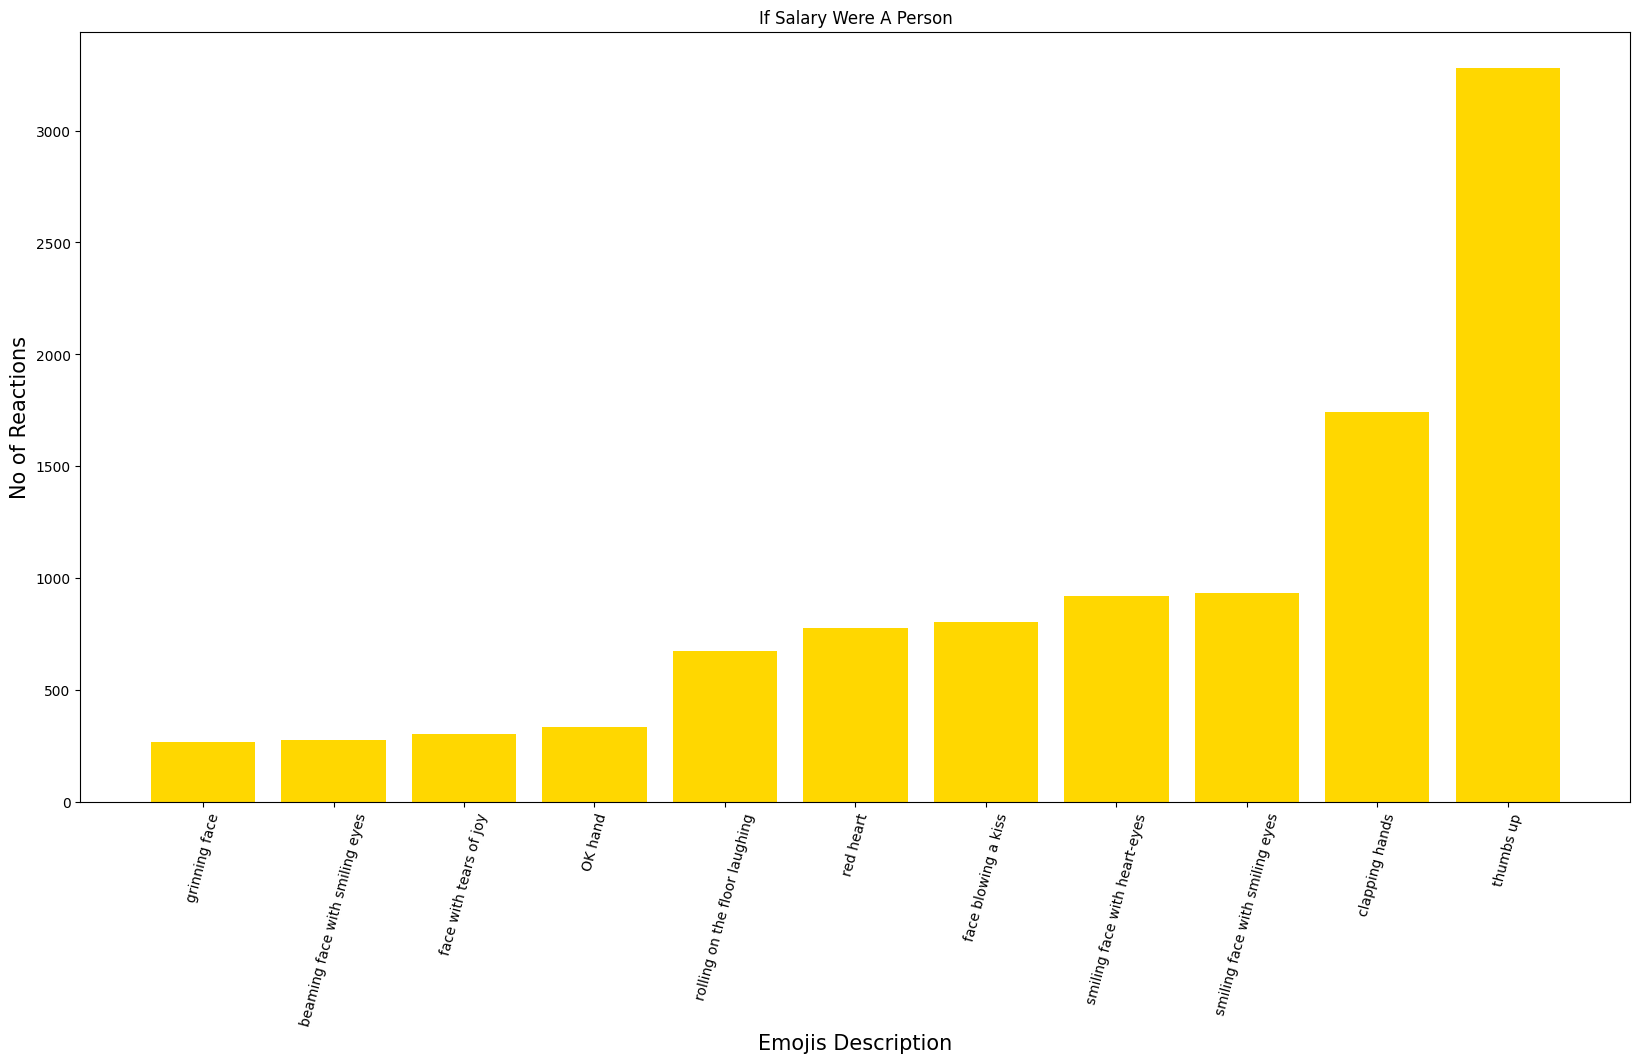

In [38]:
comment_string=''
for comment in df2['Comment']:
    try:
        comment_string+=comment
    except:
        pass
emos=demoji.findall(comment_string)
count_all=Counter(comment_string)
count_emos={}
for i in emos:
    if(count_all.get(i)!=None):
        count_emos[i]=count_all.get(i)
    else:
        pass
count_emos={k: v for k, v in sorted(count_emos.items(), key=lambda item: item[1])}
label=" ".join(list(count_emos.keys())[-11:])
label=list(demoji.findall(label).values())
y=list(count_emos.values())[-11:]
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(label,y,color='gold')
plt.xticks(label=label,rotation=75)
plt.xlabel('Emojis Description',fontsize=15)
plt.ylabel('No of Reactions',fontsize=15)
plt.title('If Salary Were A Person')
plt.show()

## TimeSeries Analysis of Both the Videos

In [39]:
def show_timeseries(df_,title):    
    df_['ts']=pd.to_datetime(df_['Time'])
    df_['hour']=df_['ts'].apply(lambda x:x.hour)
    df_['date']=df_['ts'].apply(lambda x:x.day)
    df_['month']=df_['ts'].apply(lambda x:x.month)
    df_['year']=df_['ts'].apply(lambda x:x.year)
    dates=[date for date in df_['date'].unique()]
    dates.sort()
    y=[df_[(df_['date']==date) & (df_['month']==3) &(df_['year']==2021)]['Comment'].count() for date in dates]
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(dates,y)
#     ax.set_xticks(np.arange(len(dates)))
#     ax.set_xticklabels(dates)
    plt.title(title,fontsize=20)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Comments',fontsize=15)
    plt.show()

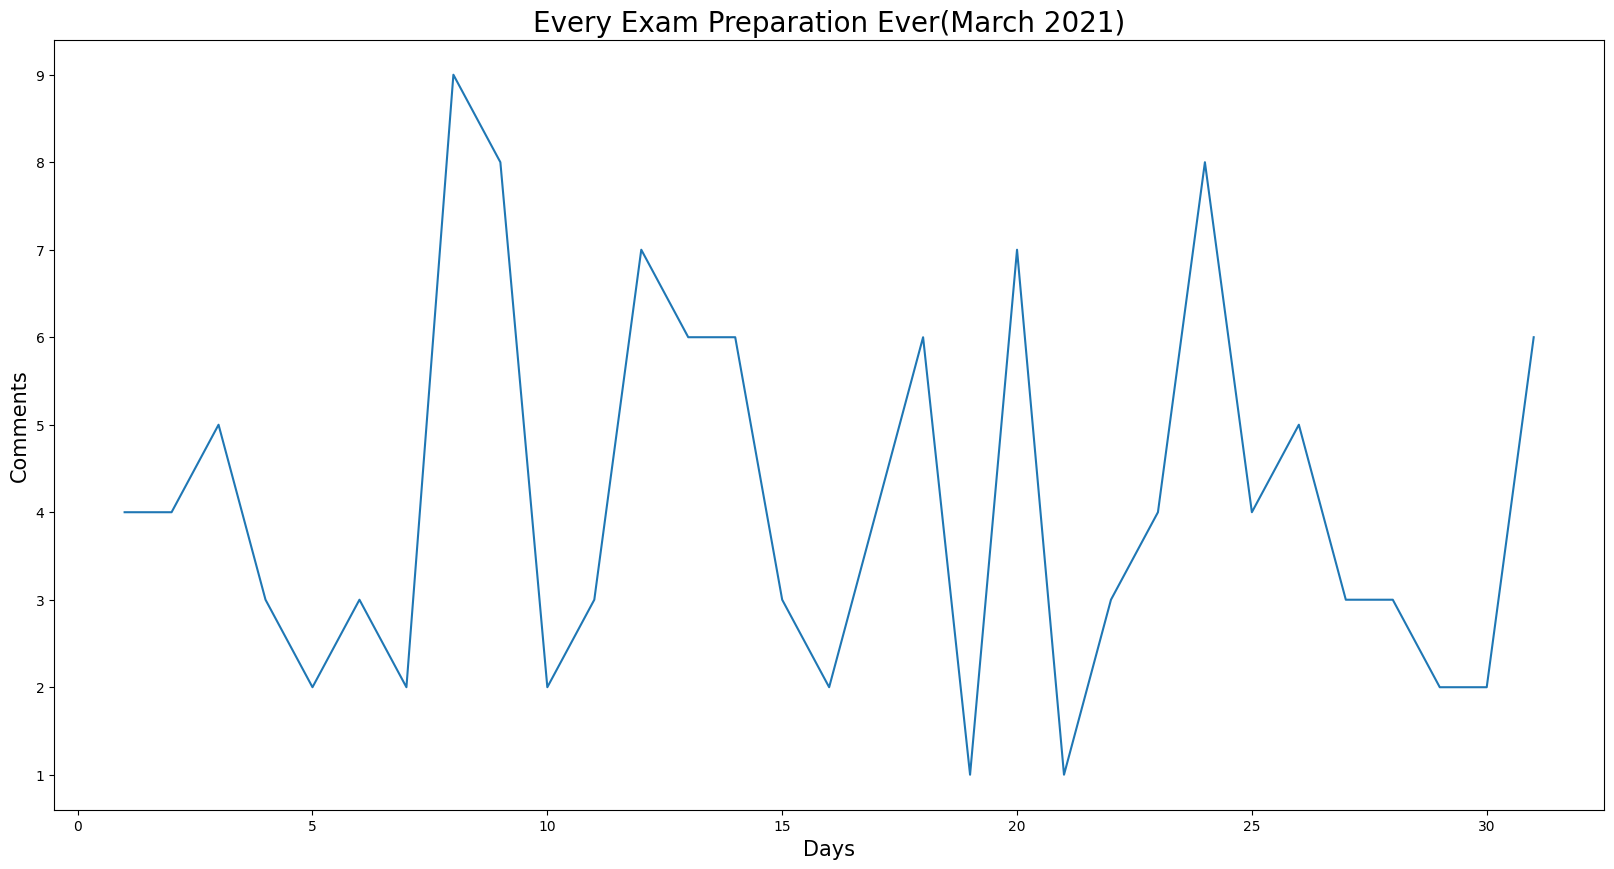

In [40]:
show_timeseries(df.copy(),'Every Exam Preparation Ever(March 2021)')

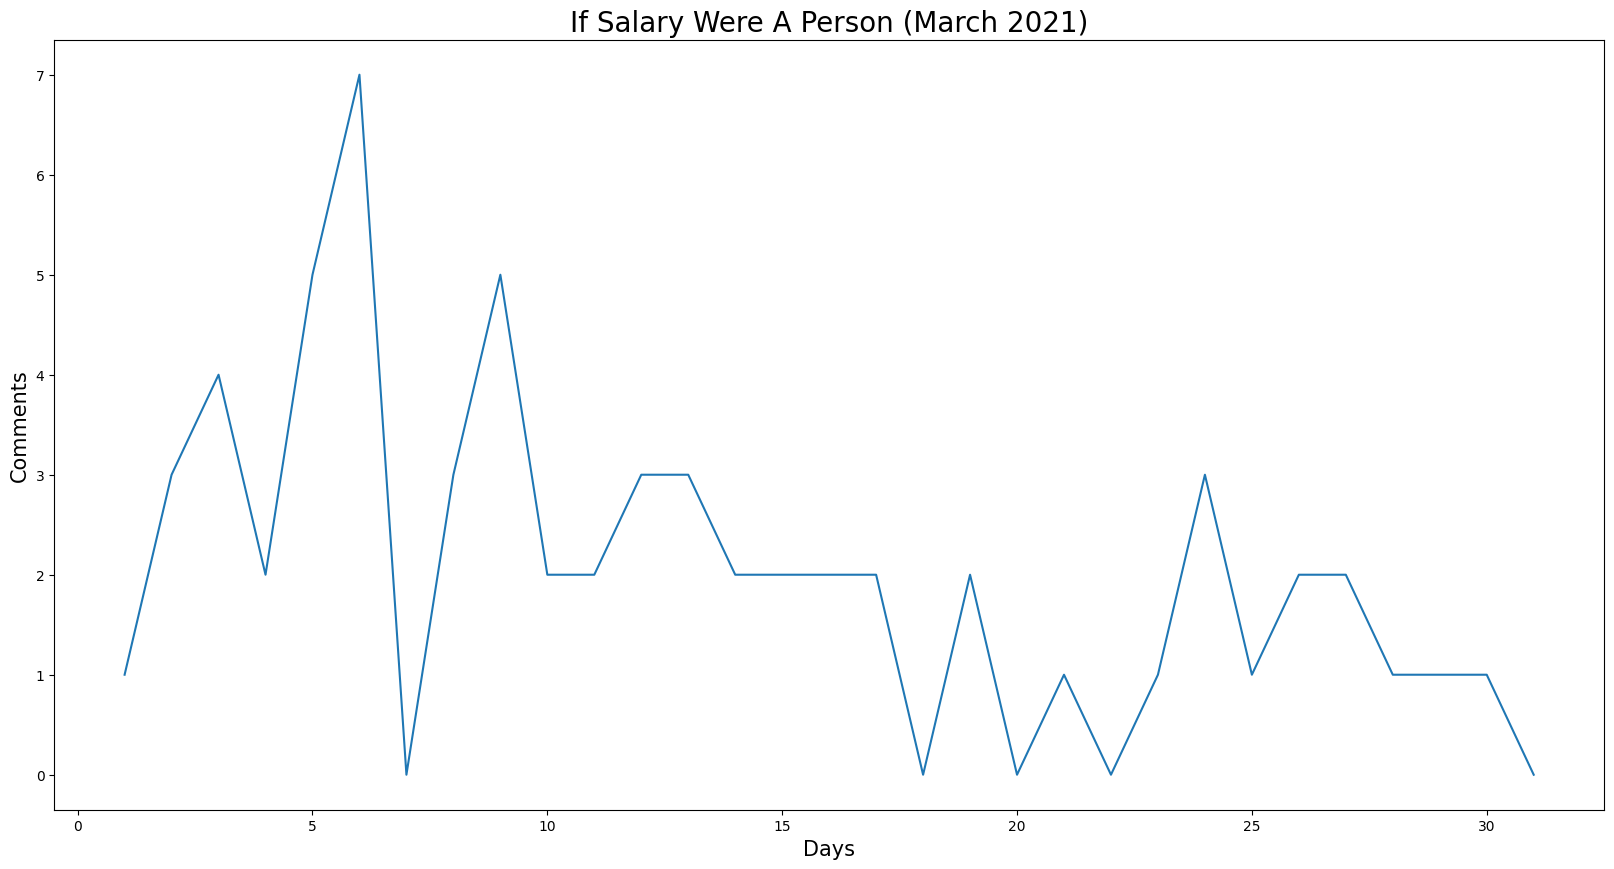

In [41]:
show_timeseries(df2.copy(),'If Salary Were A Person (March 2021)')

In [42]:
def show_timeseries_month(df_,title):    
    df_['ts']=pd.to_datetime(df_['Time'])
    df_['hour']=df_['ts'].apply(lambda x:x.hour)
    df_['date']=df_['ts'].apply(lambda x:x.day)
    df_['month']=df_['ts'].apply(lambda x:x.month)
    df_['year']=df_['ts'].apply(lambda x:x.year)
    months=[month for month in df_['month'].unique()]
    months.sort()
    y=[df_[(df_['month']==month) & (df_['year']==2020)]['Comment'].count() for month in months]
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(months,y)
#     ax.set_xticks(np.arange(len(months)))
#     ax.set_xticklabels(months)
    plt.title(title,fontsize=20)
    plt.xlabel('Months',fontsize=15)
    plt.ylabel('Comments',fontsize=15)
    plt.show()

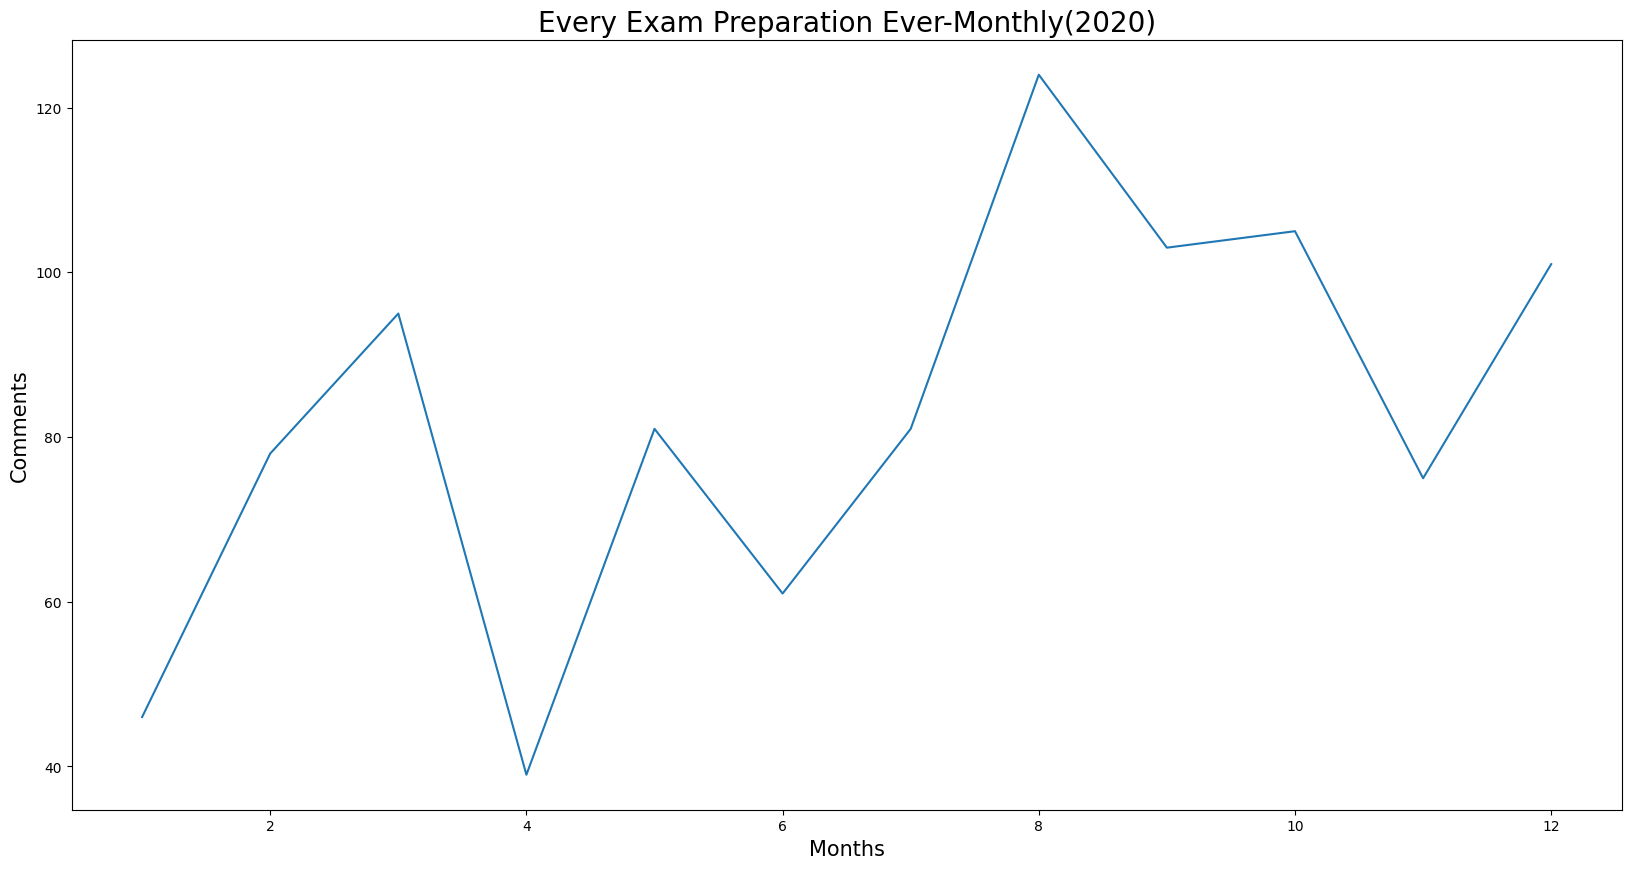

In [43]:
show_timeseries_month(df.copy(),'Every Exam Preparation Ever-Monthly(2020)')

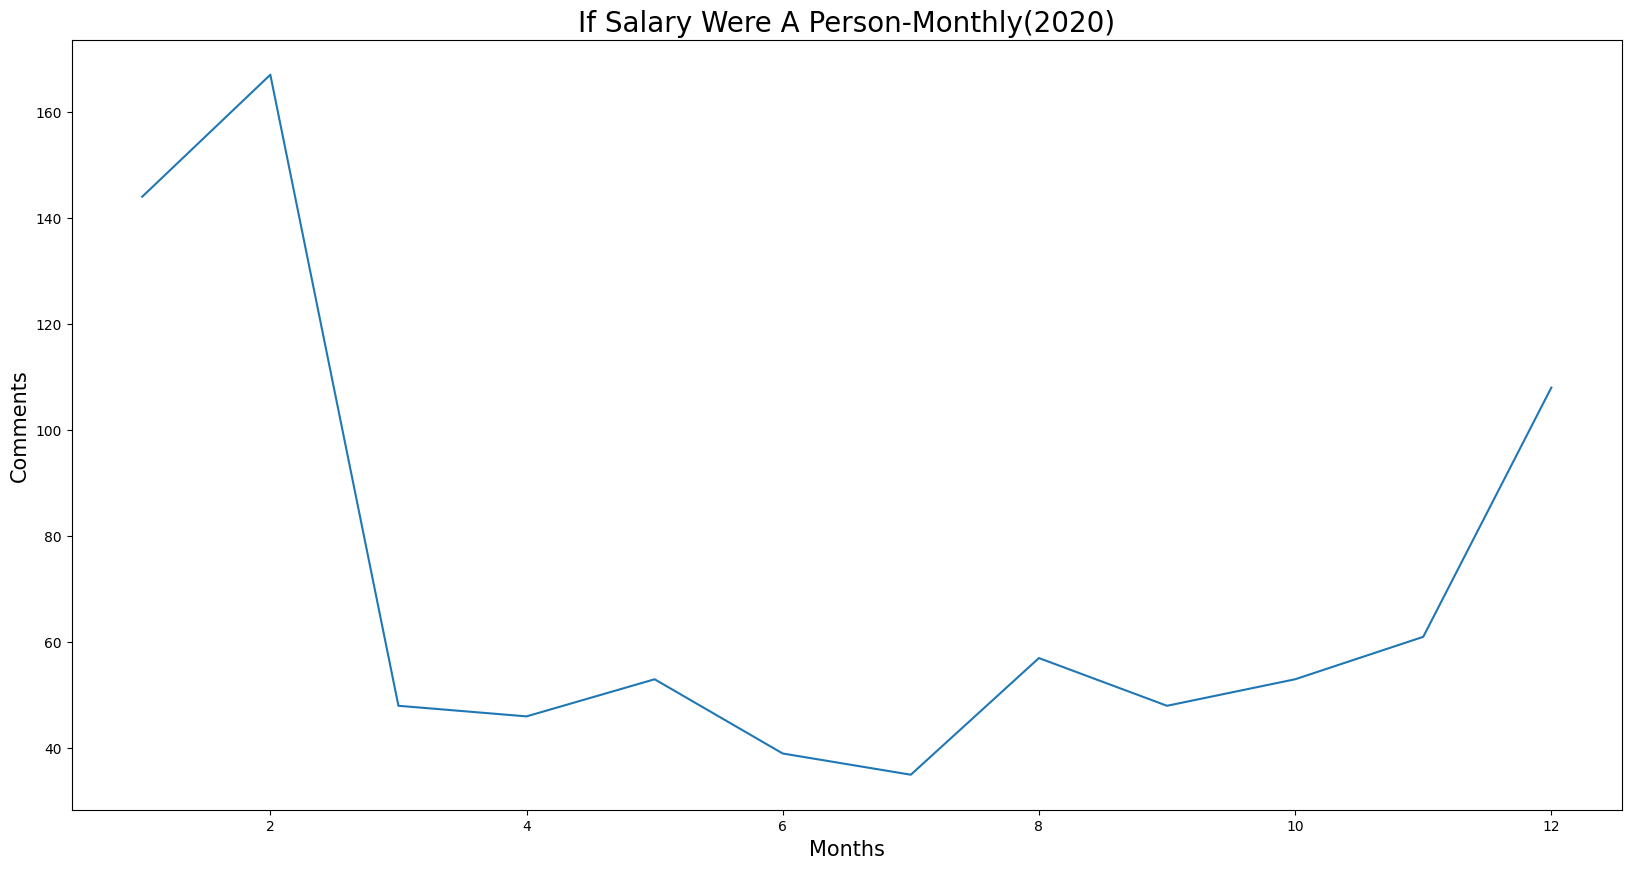

In [44]:
show_timeseries_month(df2.copy(),'If Salary Were A Person-Monthly(2020)')

In [45]:
def show_timeseries_year(df_,title):    
    df_['ts']=pd.to_datetime(df_['Time'])
    df_['hour']=df_['ts'].apply(lambda x:x.hour)
    df_['date']=df_['ts'].apply(lambda x:x.day)
    df_['month']=df_['ts'].apply(lambda x:x.month)
    df_['year']=df_['ts'].apply(lambda x:x.year)
    years=[year for year in df_['year'].unique()]
    years.sort()
    y=[df_[(df_['year']==year)]['Comment'].count() for year in years]
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(years,y)
#     ax.set_xticks(np.arange(len(years)))
#     ax.set_xticklabels(l)
    plt.xticks(range(2018,2022))
    plt.title(title,fontsize=20)
    plt.xlabel('Years',fontsize=15)
    plt.ylabel('Comments',fontsize=15)
    plt.show()

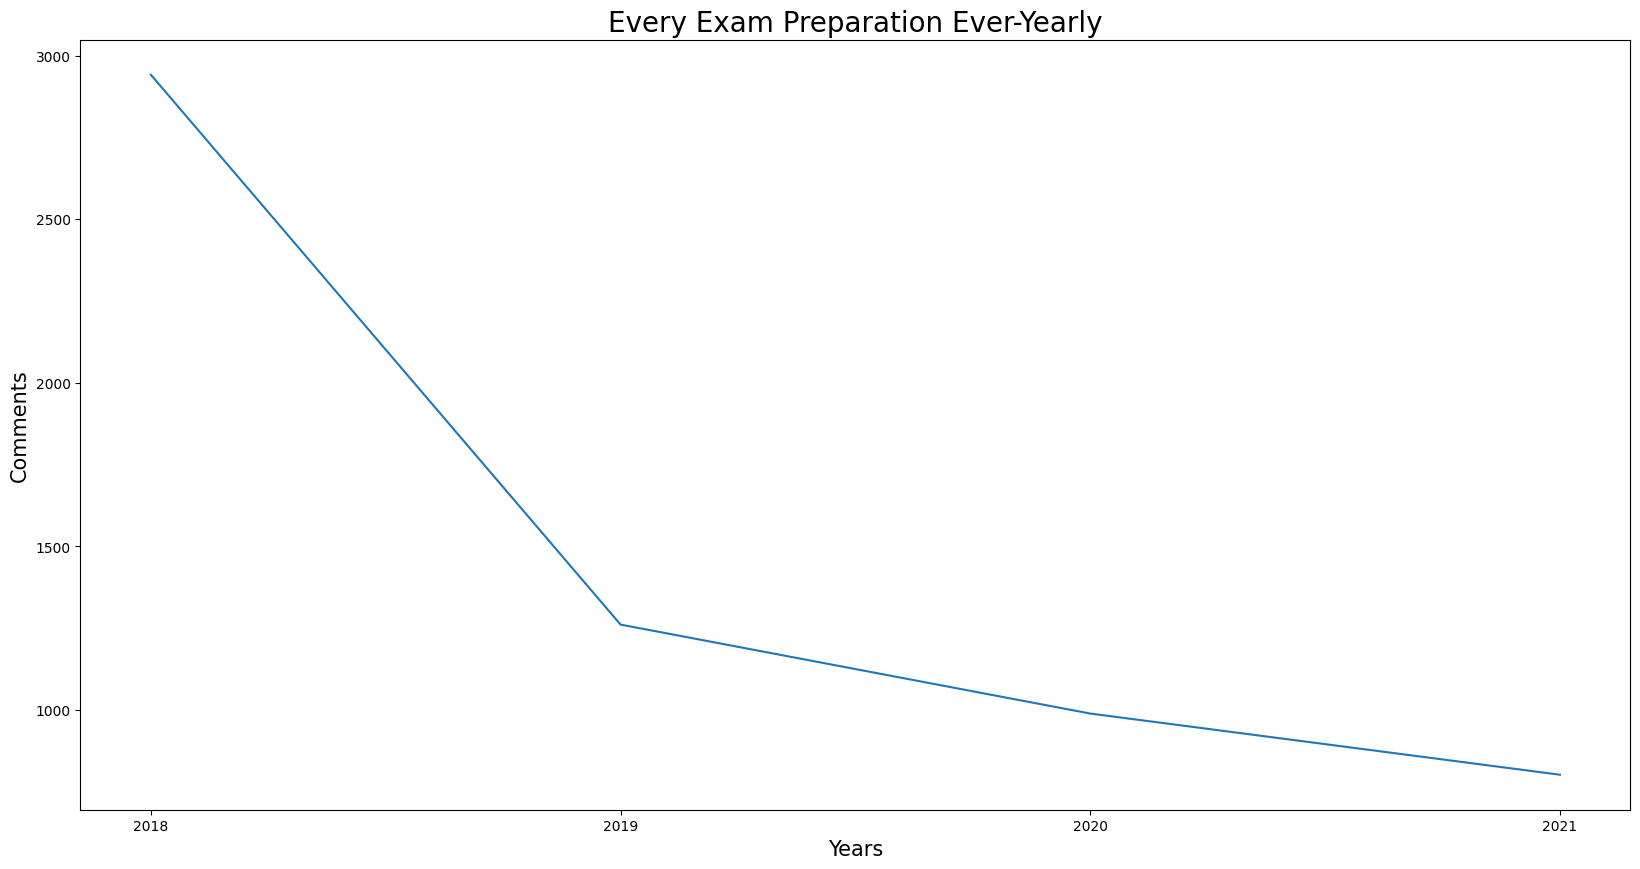

In [46]:
show_timeseries_year(df.copy(),'Every Exam Preparation Ever-Yearly')

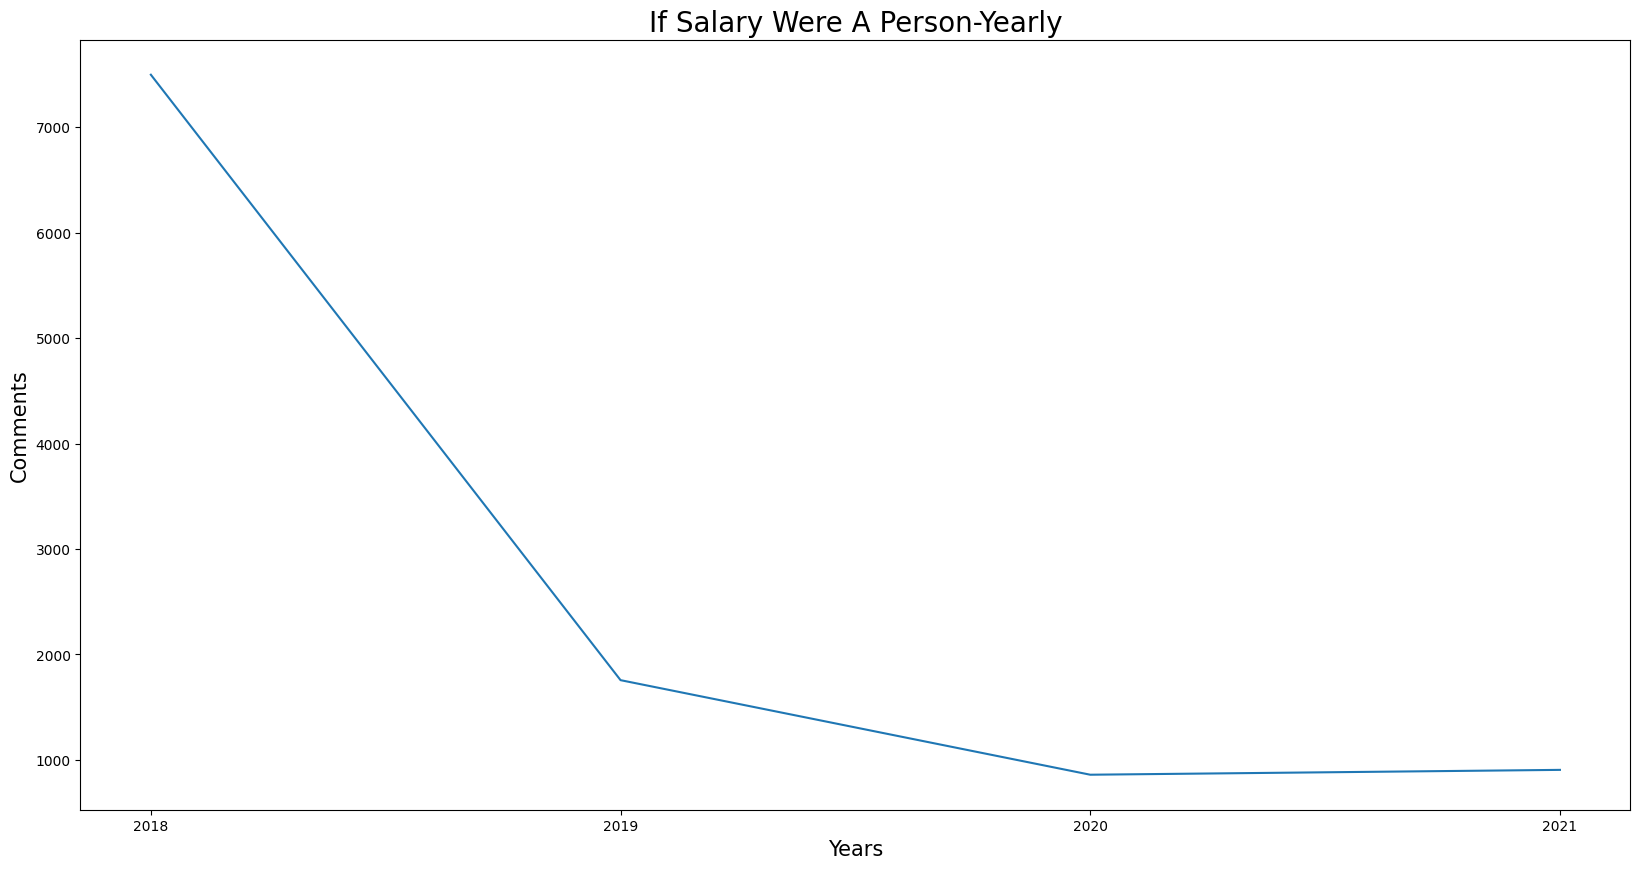

In [47]:
show_timeseries_year(df2.copy(),'If Salary Were A Person-Yearly')

It is Quite Evident that most number of the comments were in the year **2018** since that was the **initial Year of Release for both the videos**

And The Overall Analysis indicates that **IF Salary Were A Person** is more Popular.

### Persons Who Commented On Both Videos 

In [48]:
df.merge(df2,how='inner',on='Name')[['Name','Comment_x','Comment_y']]

,Name,Comment_x,Comment_y
0,Aditya Gupta,"<a href=""https://www.youtube.com/watch?v=Xd5yI...",Amazing video content !! I love this video !! ...
1,Himanshu sharma,75% views of this video is all because of ashi...,She is cute + gorgeous + hot af
2,Himanshu sharma,75% views of this video is all because of ashi...,It was fantastic 👍
3,Manish Kumar,No hc verma is harmed during this video,What a unique thought...i love it...awesome vi...
4,Manish Kumar,No hc verma is harmed during this video,Superb creation yaar.
...,...,...,...
297,Brunda RB,Finally!! Ashish on filter copy..<br>Filter co...,What aa content FilterCopy 👏👏<br>Kaha se soch...
298,Divya U. S.,Deal cancel 😂😂😂😂,Amazing concept filter Cofee 😍
299,Abhisek Shandil,Always...the best....😍😍,That &quot;hattttt&quot; mann.. 😂😂😂
300,FilterCopy,Share this with all your friends who are a ner...,What do you spend your salary on? Comment belo...


In [49]:
df3=pd.read_excel('Comments - PFA S2.xlsx')

In [50]:
df3.head()

,Name,Comment,Time,Likes,Reply Count
0,Dice Media,How did you guys like the episode? ❤️ Tell us ...,2020-10-30T07:34:03Z,3865,347
1,A-10 Sneha Gaikwad,Venkat 😂,2021-09-15T20:24:56Z,0,0
2,Priyank Khare,This show is aging well,2021-09-14T17:12:10Z,0,0
3,Manish Kumar,.<br><br><br><br><br><br><br><br><br><br><br><...,2021-09-14T17:08:57Z,0,0
4,Manish Kumar,.,2021-09-14T17:08:35Z,0,0


In [51]:
demoji.replace(df3['Comment'][6],"")

'Hey barkha give me your number'

In [52]:
df3.shape

(5667, 5)

We are Going to Use the Same Model For **Sentiment Classification.**

In [53]:
df3['Sentiment']=df3['Comment'].apply(lambda x:classifier(str(x))[0]['label'] if(len(str(x))<1000) else None)

In [54]:
df3['Sentiment']=df3['Sentiment'].apply(lambda x:mapper[x] if(x!=None) else None)

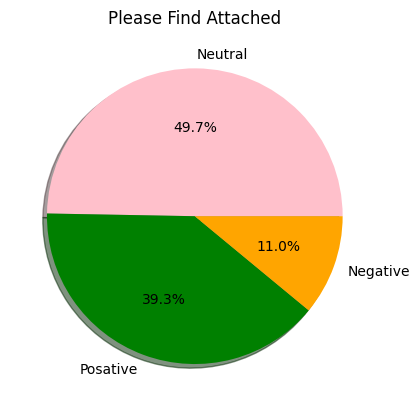

In [55]:
plt.pie(df3['Sentiment'].value_counts().values,labels=['Neutral','Posative','Negative'],colors=['pink','green','orange'],normalize=True, textprops = dict(color ="black"),shadow=True,autopct='%1.1f%%')
plt.title('Please Find Attached')
plt.show()

In [56]:
name_counter=[]
for i in df3['Comment'].values:
    if ('ayush' in str(i).lower() and 'barkha' in str(i).lower()):
        name_counter.append('Both')
    elif 'barkha' in str(i).lower():
        name_counter.append('Barkha')
    elif 'ayush' in str(i).lower():
        name_counter.append('Ayush')
    else:
        name_counter.append(None)

In [57]:
df3['Actor Mentioned']=name_counter

In [58]:
df3[df3['Actor Mentioned']=='Both']

,Name,Comment,Time,Likes,Reply Count,Sentiment,Actor Mentioned
13,Soumik Bera,"<a href=""https://www.youtube.com/watch?v=8PHs0...",2021-09-11T16:04:01Z,0,0,Neutral,Both
44,Adarsh Yadav,I want to see Ayush and barkha together a one...,2021-08-02T17:44:04Z,0,0,Neutral,Both
55,Rachana L,Literally barkha and Ayush will make a good pa...,2021-07-17T05:01:56Z,1,0,Posative,Both
63,Sejal Chaudhary,Barkha and Ayush together looking so cute 😀😍❤❤,2021-07-08T17:30:24Z,1,0,Posative,Both
72,CR MOTIONS,Here&#39;s a teaser of ayush mehra and barkha ...,2021-06-29T09:34:43Z,0,0,Neutral,Both
...,...,...,...,...,...,...,...
5633,its. aman,The most beautiful and cute couple ever! ❤️ 🔥 ...,2020-10-30T07:00:23Z,51,4,Posative,Both
5639,Praneeta Ramasamy,For sure this has been my longest wait ever!! ...,2020-10-30T06:59:49Z,37,2,Posative,Both
5642,Kumar Ayush,Ayush nd barkha best jodi😄😄😄😄,2020-10-30T06:59:18Z,0,0,Posative,Both
5653,Upasana Saha,Barkha and Ayush(Sanya and Shaurya) be the bes...,2020-10-30T06:57:33Z,2,0,Posative,Both


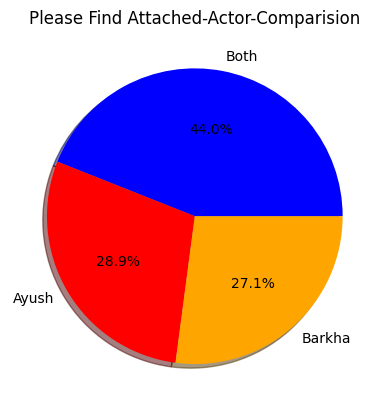

In [59]:
plt.pie(df3['Actor Mentioned'].value_counts().values,labels=['Both','Ayush','Barkha'],colors=['blue','red','orange'],normalize=True, textprops = dict(color ="black"),shadow=True,autopct='%1.1f%%')
plt.title('Please Find Attached-Actor-Comparision')
plt.show()

In [60]:
barkha=df3[df3['Actor Mentioned']=='Barkha']['Sentiment'].value_counts()
ayush=df3[df3['Actor Mentioned']=='Ayush']['Sentiment'].value_counts()
both=df3[df3['Actor Mentioned']=='Both']['Sentiment'].value_counts()

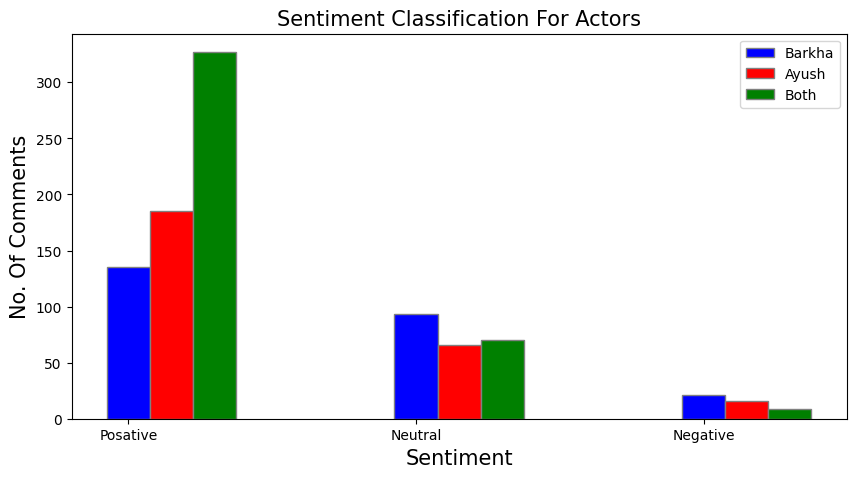

In [61]:
barWidth = 0.15
fig=plt.subplots(figsize=(10,5))
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3=[x+barWidth for x in br2]
plt.bar(br1,barkha.values,color='blue',label='Barkha',width=barWidth,edgecolor='grey')
plt.bar(br2,ayush.values,color='red',label='Ayush',width=barWidth,edgecolor='grey')
plt.bar(br3,both.values,color='green',label='Both',width=barWidth,edgecolor='grey')
plt.xlabel('Sentiment', fontsize = 15)
plt.ylabel('No. Of Comments', fontsize = 15)
plt.xticks([0,1,2],['Posative','Neutral','Negative'])
plt.title('Sentiment Classification For Actors',fontsize=15)
plt.legend()
plt.show()

From the Above Graph it is safe to say that **Ayush gets more posative comments than Barkha** and **both of them together is praised very well**. Also **Barkha seems to get a liitle bit more criticism than Ayush.** 